In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load datasets
train_data = pd.read_csv('train2_six_way.csv')
val_data = pd.read_csv('valid2_six_way.csv')
test_data = pd.read_csv('test2_six_way.csv')

In [3]:
# Inspect data to identify relevant columns
print(train_data.head())

   label                                          statement  __index_level_0__
0    1.0  Says the Annies List political group supports ...                0.0
1    3.0  When did the decline of coal start? It started...                1.0
2    4.0  Hillary Clinton agrees with John McCain "by vo...                2.0
3    1.0  Health care reform legislation is likely to ma...                3.0
4    3.0  The economic turnaround started at the end of ...                4.0


In [4]:
# Extract features and labels
X_train = train_data['statement']
y_train = train_data['label']
X_val = val_data['statement']
y_val = val_data['label']
X_test = test_data['statement']
y_test = test_data['label']

# Combine train and validation data for Grid Search
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])

In [5]:
# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_combined_vectorized = vectorizer.fit_transform(X_combined)
X_test_vectorized = vectorizer.transform(X_test)

In [6]:
# Perform Grid Search to find best hyperparameters
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           scoring='accuracy',
                           n_jobs=-1)

grid_search.fit(X_combined_vectorized, y_combined)

# Best model from Grid Search
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 500}


In [7]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_classes = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')

    print(f"\n=== {model_name} Performance ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes))

    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    return acc, f1, precision, recall


=== RandomForest Performance ===
Accuracy: 0.2502
F1-Score: 0.2000
Precision: 0.2210
Recall: 0.2502

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.17      0.26        92
           1       0.24      0.41      0.30       249
           2       0.22      0.01      0.02       212
           3       0.25      0.49      0.33       265
           4       0.24      0.28      0.26       241
           5       0.00      0.00      0.00       208

    accuracy                           0.25      1267
   macro avg       0.25      0.23      0.20      1267
weighted avg       0.22      0.25      0.20      1267



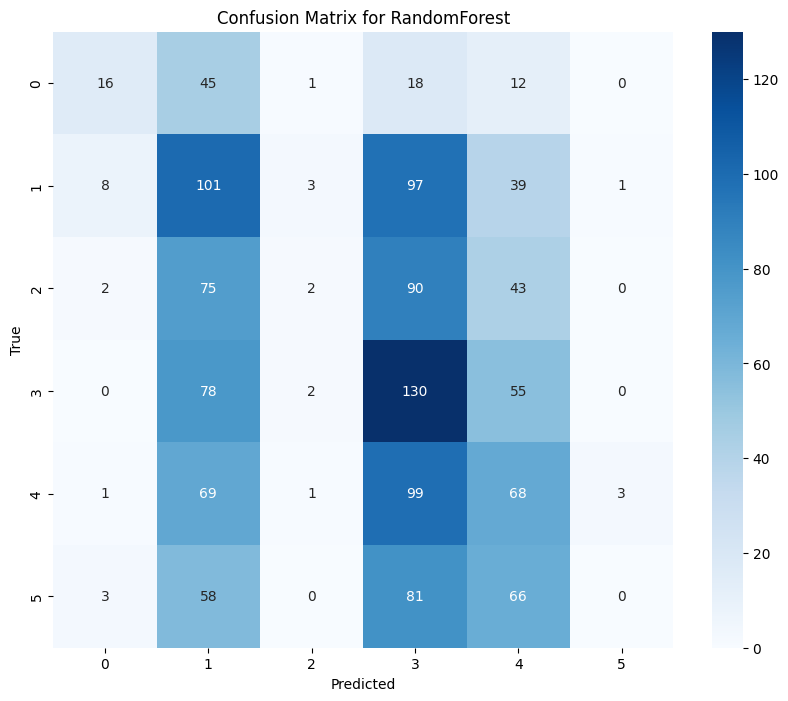


Random Forest Results:
{'Model': 'RandomForest', 'Best Params': {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 500}, 'CV Accuracy': 0.24644364605929142, 'Test Accuracy': 0.250197316495659, 'Test F1-Score': 0.19997376386967747, 'Precision': 0.22100577753540576, 'Recall': 0.250197316495659}


In [9]:
# Extract best estimator for Random Forest
best_model = grid_search.best_estimator_
cv_accuracy_rf = grid_search.best_score_
acc_rf, f1_rf, precision_rf, recall_rf = evaluate_model(best_model, X_test_vectorized, y_test, 'RandomForest')

rf_results = {
    'Model': 'RandomForest',
    'Best Params': grid_search.best_params_,
    'CV Accuracy': cv_accuracy_rf,
    'Test Accuracy': acc_rf,
    'Test F1-Score': f1_rf,
    'Precision': precision_rf,
    'Recall': recall_rf
}

print("\nRandom Forest Results:")
print(rf_results)